# **3DBallEnv Reinforcement Learning**

In [1]:
ENV_PATH = "../../../envs/3DBall"

### **Imports**

In [2]:
### Utility
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tempfile
import time
import os

### Torch
import torch
from torch import nn
from torch import optim

# Model
from model_util import MLP

### Torch RL
# Env
from torchrl.envs.libs import UnityMLAgentsEnv
from mlagents_envs.side_channel.engine_configuration_channel import EngineConfigurationChannel
from torchrl.envs.utils import step_mdp, check_env_specs
from torchrl.envs import TransformedEnv, Stack, ExcludeTransform

# Modules
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torchrl.modules import ProbabilisticActor, TanhNormal
from torch.distributions import Categorical, Normal, Independent

# Data Collection
from torchrl.collectors import SyncDataCollector, MultiSyncDataCollector
from torchrl.collectors.utils import split_trajectories
from torchrl.data import LazyTensorStorage, ReplayBuffer, Composite
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from tensordict import TensorDict, TensorDictBase

# Loss
from torchrl.objectives import ClipPPOLoss, ValueEstimators

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Using Device: cpu


## **Create Torch Env**

In [4]:
def create_unity_env(graphics=False, **kwargs):
    try:
        env.close()
    except:
        pass
    
    env = TransformedEnv(UnityMLAgentsEnv(
        file_name=ENV_PATH, worker_id=np.random.randint(10000), 
        no_graphics=(not graphics), **kwargs,
        device="cpu",
    ))

    return env

### **Agents not Batched**

In [5]:
def print_specs(env):
    print("action_spec:", env.action_spec)
    print("reward_spec:", env.reward_spec)
    print("done_spec:", env.done_spec)
    print("observation_spec:", env.observation_spec)

env = create_unity_env()
check_env_specs(env)
print_specs(env)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [6]:
agent_root_key = env.observation_keys[0][0]
print(agent_root_key)
n_agents = len(env.action_spec[agent_root_key])
print(n_agents)
agents = list(env.action_spec[agent_root_key].keys())
print(agents)

group_0
12
['agent_0', 'agent_1', 'agent_2', 'agent_3', 'agent_4', 'agent_5', 'agent_6', 'agent_7', 'agent_8', 'agent_9', 'agent_10', 'agent_11']


In [7]:
env.rollout(100)

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


TensorDict(
    fields={
        group_0: TensorDict(
            fields={
                agent_0: TensorDict(
                    fields={
                        VectorSensor_size8: Tensor(shape=torch.Size([13, 8]), device=cpu, dtype=torch.float32, is_shared=False),
                        continuous_action: Tensor(shape=torch.Size([13, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                        done: Tensor(shape=torch.Size([13, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                        terminated: Tensor(shape=torch.Size([13, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                        truncated: Tensor(shape=torch.Size([13, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
                    batch_size=torch.Size([13]),
                    device=cpu,
                    is_shared=False),
                agent_10: TensorDict(
                    fields={
                        VectorSensor_size8: Tensor(shape=torch.Size(

### **Batch Agents**

In [8]:
def batch_agents(env, out_key="agents"):
    agent_root_key = env.observation_keys[0][0]
    agents = list(env.action_spec[agent_root_key].keys())
    
    # Create transform
    stack = Stack(
        in_keys=[(agent_root_key, agent) for agent in agents], 
        out_key=(out_key,), 
        in_key_inv=(out_key,), 
        out_keys_inv=[(agent_root_key, agent) for agent in agents]
    )

    env.append_transform(stack)
    return env

def create_base_env(graphics=False, **kwargs):
    env = create_unity_env(graphics, **kwargs)
    env = batch_agents(env)
    return env

In [9]:
env = create_base_env()

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [10]:
check_env_specs(env)
print_specs(env)

ERROR: Shader UI/Default shader is not supported on this GPU (none of subshaders/fallbacks are suitable)
2025-09-30 10:44:47,205 [torchrl][INFO]    check_env_specs succeeded! [END]
action_spec: Composite(
    agents: Composite(
        continuous_action: BoundedContinuous(
            shape=torch.Size([12, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([12, 2]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([12, 2]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        device=cpu,
        shape=torch.Size([12]),
        data_cls=None),
    device=cpu,
    shape=torch.Size([]),
    data_cls=None)
reward_spec: Composite(
    agents: Composite(
        reward: UnboundedContinuous(
            shape=torch.Size([12, 1]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([12, 1]), device

In [11]:
td = env.rollout(100)
td

TensorDict(
    fields={
        agents: TensorDict(
            fields={
                VectorSensor_size8: Tensor(shape=torch.Size([14, 12, 8]), device=cpu, dtype=torch.float32, is_shared=False),
                continuous_action: Tensor(shape=torch.Size([14, 12, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([14, 12, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                terminated: Tensor(shape=torch.Size([14, 12, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([14, 12, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([14, 12]),
            device=cpu,
            is_shared=False),
        next: TensorDict(
            fields={
                agents: TensorDict(
                    fields={
                        VectorSensor_size8: Tensor(shape=torch.Size([14, 12, 8]), device=cpu, dtype=torch.float32, is_shared=False

## **Env Data Preprocessing**

In [12]:
env = create_base_env()

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

### **Inspect Keys**

In [13]:
observation_key = env.observation_keys[0][1]
action_key = env.action_key[1]
print(f"observation_key: {observation_key}, action_key: {action_key}")

observation_shape = env.observation_spec["agents", observation_key].shape
action_shape = env.action_spec["agents", action_key].shape

print(f"observation_shape: {observation_shape}, action_shape: {action_shape}")

observation_key: VectorSensor_size8, action_key: continuous_action
observation_shape: torch.Size([12, 8]), action_shape: torch.Size([12, 2])


### **Inspect Action Space**

Actions are in [-1, 1] as expected. No need for further tampering

In [14]:
td = env.rollout(100)
actions_df = pd.DataFrame({
    "action": td["agents", action_key].reshape(-1)
})
actions_df.describe()

ERROR: Shader UI/Default shader is not supported on this GPU (none of subshaders/fallbacks are suitable)


,action
count,360.000000
mean,0.008095
std,0.582630
min,-0.997823
25%,-0.520476
50%,0.000710
75%,0.533737
max,0.979947


In [15]:
space = env.action_spec["agents", action_key].space
print("low:", float(space.low[0, 0]), "high:", float(space.high[0, 0]))

low: -1.0 high: 1.0


### **Inspect Observation Space**

Observation are around z score normalized. No need for further tampering

In [16]:
obs_df = pd.DataFrame({
    "obs": td["agents", observation_key].reshape(-1)
})
obs_df.describe()

,obs
count,1440.000000
mean,0.193852
std,1.458232
min,-5.101198
25%,-0.547335
50%,-0.011345
75%,0.272398
max,3.996076


In [17]:
env.observation_spec["agents", observation_key]

UnboundedContinuous(
    shape=torch.Size([12, 8]),
    space=ContinuousBox(
        low=Tensor(shape=torch.Size([12, 8]), device=cpu, dtype=torch.float32, contiguous=True),
        high=Tensor(shape=torch.Size([12, 8]), device=cpu, dtype=torch.float32, contiguous=True)),
    device=cpu,
    dtype=torch.float32,
    domain=continuous)

### **Inspect Reward Space**

It looks like group_reward can be safely ignored. While the reward is -1 on failure, and 0.1 for surviving.

In [18]:
reward_df = pd.DataFrame({
    "reward": td["next", "agents", "reward"].reshape(-1),
    "group_reward": td["next", "agents", "group_reward"].reshape(-1)
})
reward_df.describe()

,reward,group_reward
count,180.000000,180.0
mean,0.087778,0.0
std,0.084995,0.0
min,-1.000000,0.0
25%,0.100000,0.0
50%,0.100000,0.0
75%,0.100000,0.0
max,0.100000,0.0


In [19]:
reward_df

,reward,group_reward
0,0.1,0.0
1,0.1,0.0
2,0.1,0.0
3,0.1,0.0
4,0.1,0.0
...,...,...
175,0.0,0.0
176,0.0,0.0
177,0.0,0.0
178,0.0,0.0


### **Finalize Environment**
The environment is already in a good state, the only thing to do is exclude group_reward.

In [20]:
def create_env(graphics=False, time_scale = 1, **kwargs):
    # Time scale
    if time_scale != 1:
        engine_config_channel = EngineConfigurationChannel()
        env = create_base_env(graphics, **kwargs, side_channels=[engine_config_channel])
        engine_config_channel.set_configuration_parameters(time_scale=time_scale)
    else:
        env = create_base_env(graphics, **kwargs)

    # Exclude group reward
    env.append_transform(
        ExcludeTransform(("agents", "group_reward"))
    )
    return env

In [21]:
env = create_env()
check_env_specs(env)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [22]:
step_mdp(env.rollout(20))

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


TensorDict(
    fields={
        agents: TensorDict(
            fields={
                VectorSensor_size8: Tensor(shape=torch.Size([13, 12, 8]), device=cpu, dtype=torch.float32, is_shared=False),
                continuous_action: Tensor(shape=torch.Size([13, 12, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                done: Tensor(shape=torch.Size([13, 12, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                reward: Tensor(shape=torch.Size([13, 12, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                terminated: Tensor(shape=torch.Size([13, 12, 1]), device=cpu, dtype=torch.bool, is_shared=False),
                truncated: Tensor(shape=torch.Size([13, 12, 1]), device=cpu, dtype=torch.bool, is_shared=False)},
            batch_size=torch.Size([13, 12]),
            device=cpu,
            is_shared=False)},
    batch_size=torch.Size([13]),
    device=cpu,
    is_shared=False)

## **Create Models**

### **Config**

In [23]:
env = create_env()
observation_key = env.observation_keys[0][1]
action_key = env.action_key[1]

observation_shape = int(env.observation_spec["agents", observation_key].shape[-1])
action_shape = int(env.action_spec["agents", action_key].shape[-1])

HIDDEN_DIM = 256
N_BLOCKS = 3

MODEL_CONFIG = {
    "hidden_dim": HIDDEN_DIM,
    "n_blocks": N_BLOCKS,
    "in_features": observation_shape,
    "out_features": action_shape,
}

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [24]:
MODEL_CONFIG

{'hidden_dim': 256, 'n_blocks': 3, 'in_features': 8, 'out_features': 2}

### **Policy**

In [25]:
def create_policy(config):
    config = config.copy()
    config["out_features"] *= 2 # Double output dim, for loc and scale
    model = MLP(**config)

    normal_params_model = nn.Sequential(
        model,
        NormalParamExtractor()
    )
    logits_model = TensorDictModule(normal_params_model, in_keys=[("agents", observation_key)], out_keys=[("agents", "loc"), ("agents", "scale")])
    policy = ProbabilisticActor(
        module=logits_model,  
        distribution_class=TanhNormal,

        in_keys=[("agents", "loc"), ("agents", "scale")],
        out_keys=[("agents", action_key)],

        return_log_prob=True,
        log_prob_key=("agents", "log_prob"),
        cache_dist=True,
    )

    return policy

### **Value**

In [26]:
def create_value(config):
    # Remove out_features from config
    config = config.copy()
    config["out_features"] = 1

    model = MLP(**config)
    value = TensorDictModule(model, in_keys=[("agents", observation_key)], out_keys=[("agents", "state_value")])
    return value

### **PPO Loss Module**

In [27]:
def make_loss_module(policy, value, epsilon, entropy_coef, gamma, lmbda):
    loss_module = ClipPPOLoss(
        actor_network=policy,
        critic_network=value,
        clip_epsilon=epsilon,
        entropy_coeff=entropy_coef,
        # normalize_advantage=True,
    )
    
    loss_module.set_keys(
        action=("agents", action_key),
        sample_log_prob=("agents", "log_prob"),
        value=("agents", "state_value"),

        advantage=("agents", "advantage"),
        value_target=("agents", "value_target"),

        reward=("agents", "reward"),
        done=("agents", "done"),
        terminated=("agents", "terminated"),
        # truncated can be left out, PPO uses done/terminated for bootstrapping
    )

    loss_module.make_value_estimator(ValueEstimators.GAE, gamma=gamma, lmbda=lmbda)

    return loss_module

### **Inspect**

In [28]:
policy, value = create_policy(MODEL_CONFIG).to(device), create_value(MODEL_CONFIG).to(device)
loss_module = make_loss_module(policy, value, epsilon=0.1, entropy_coef=0.01, gamma=0.99, lmbda=0.95).to(device)

with torch.no_grad():
    td = env.rollout(100, policy=policy, auto_cast_to_device=True).to(device)
    loss_module.value_estimator(td)
data = step_mdp(td)["agents"]
data

ERROR: Shader UI/Default shader is not supported on this GPU (none of subshaders/fallbacks are suitable)


TensorDict(
    fields={
        VectorSensor_size8: Tensor(shape=torch.Size([13, 12, 8]), device=cpu, dtype=torch.float32, is_shared=False),
        advantage: Tensor(shape=torch.Size([13, 12, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        continuous_action: Tensor(shape=torch.Size([13, 12, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        done: Tensor(shape=torch.Size([13, 12, 1]), device=cpu, dtype=torch.bool, is_shared=False),
        loc: Tensor(shape=torch.Size([13, 12, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        log_prob: Tensor(shape=torch.Size([13, 12]), device=cpu, dtype=torch.float32, is_shared=False),
        reward: Tensor(shape=torch.Size([13, 12, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        scale: Tensor(shape=torch.Size([13, 12, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        state_value: Tensor(shape=torch.Size([13, 12, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        t

## **Training**

### **Train Util**

In [29]:
# Returns dict of computed averages: return, episode_length, entropy, action_std
def compute_trajectory_metrics(tensordict_data):
    traj_data = split_trajectories(tensordict_data)

    reward = traj_data["next", "agents", "reward"] # [Tr, T, A, 1]
    if "collector" in traj_data:
        mask = traj_data["collector", "mask"].to(reward.dtype) # [Tr, T]
    elif "mask" in traj_data:
        mask = traj_data["mask"].to(reward.dtype) # [Tr, T]
    else:
        raise KeyError("No mask field found in:", tensordict_data)

    # 1. [Tr, T, A, 1] --(per episode return)--> [Tr, A] --(average return)--> float
    average_return = (reward * (mask.unsqueeze(-1).unsqueeze(-1))).sum(dim=(-3,-1)).mean().cpu().item()

    # 2. [Tr, T] --(episode length per trajectory (minumum of all agents))--> [Tr] --(average episode length)
    average_episode_length = mask.sum(dim=1).mean().cpu().item()
    
    # 3. Calculate entropy from sampled log_p since TanhNormal no closed form.
    # Masked entropy [Tr, T, A]
    entropy = (-traj_data["agents", "log_prob"]).reshape(*mask.shape, -1) * mask.unsqueeze(-1)
    # [Tr, T, A] --(mean entropy per agent (along the same timestep))--> [Tr, T]
    entropy = entropy.mean(dim=-1)
    # Total timesteps = mask.sum(), [Tr, T] --(average entropy)--> float
    entropy = (entropy.sum() / mask.sum()).cpu().item()

    # 4. action_std [T, A, action_dim]
    action_std = tensordict_data["agents", action_key].std().cpu().item()

    metrics = {
        "return": average_return,
        "episode_length": average_episode_length,
        "entropy": entropy,
        "action_std": action_std,
    }

    return metrics

# Uses loss module output tensordict and converts into a python dict with metrics
def loss_dict(loss_data, weight):
    # Hard coded keys, values
    keys = ["value_loss", "explained_variance", "policy_loss", "kl_approx", "clip_fraction", "ESS"]
    values = ["loss_critic", "explained_variance", "loss_objective", "kl_approx", "clip_fraction", "ESS"]

    return {
        key: (loss_data[value].detach().mean().cpu().item(), weight) for key, value in zip(keys, values)
    }


class Stopwatch:
    def __init__(self):
        pass

    def start(self):
        self.start_time = time.time()

    def end(self):
        return time.time() - self.start_time


In [30]:
class WEWMA:
    def __init__(self, beta):
        self.N = 0.0
        self.D = 0.0
        self.beta = beta

    def update(self, w, x):
        self.N = w*x + self.beta * self.N
        self.D =  w  + self.beta * self.D
        return self.N / self.D

class Logger:
    '''
    Simple CSV Logger
    
    Args:
        - keys
        - log_path, name 
            - (optional) log_path is the log directory and must exist beforehand.
        - beta (for ewmas)

    Usage:

    logger = Logger(keys=keys, log_path=log_path, name=name) # (full_log_path = log_path/name.csv)
    # the history is retrieved on creation of the logger
    logger.reset() # reset the logger and log file if present
    # ...
    # Do some log ops
    # ...
    logger.next(print_row=True) # Writes this row, optionally prints it
    # ...
    history_df = logger.dataframe()

    Log Ops:
        logger.add({key: value}): sets column
        logger.sum({key: value}): adds from previous column
        logger.accumulate({key: value}): (weighted) EWMA of calls (this row only, does not weight over previous rows)
            - in accumulate providing a value tuple of (value, weight) uses that weight, otherwise no tuple means weight=1
    '''

    def __init__(self, keys, log_path=None, name=None, beta=0.90):
        # Data State
        self.keys = list(keys)
        self.set_keys = set(keys)
        self.df = pd.DataFrame(columns=self.keys)

        # For Building
        self.prev_row = {} # Helps with sums
        self.row = {}
        self.wewmas = {}
        self.beta = beta
        

        # Check for log path + name
        self.log_path = log_path
        if log_path and not name:
            raise KeyError("Log path provided without name")
        self.full_log_path = None

        # Check for existing logs
        if log_path:
            self.full_log_path = os.path.join(log_path, f"{name}.csv")

            # If it exists, read current data
            if os.path.exists(self.full_log_path):
                try:
                    self.df = pd.read_csv(self.full_log_path)
                    self._set_prev_row()
                except:
                    print("FAILED TO READ LOG FILE, STARTING FROM SCRATCH.")

    ### START ###

    def _set_prev_row(self):
        if len(self.df) == 0: 
            self.prev_row = {}
            return
        self.prev_row = self.df.iloc[-1].to_dict()

    def reset(self):
        # Ignore if no path
        if self.full_log_path is None:
            print("NO LOG PATH GIVEN: SKIPPING RESET")
            return

        # Try empty/create file (fails)
        with open(self.full_log_path, "w") as f:
            pass
        self.df = pd.DataFrame(columns=self.keys)
        self._set_prev_row()

    ### INTERNAL HELPERS ###

    def _check(self, key):
        if key not in self.set_keys:
            print(f"key: {key} not in keys: {self.keys}. SKIPPING KEY")
            return False
        return True
    
    @staticmethod
    def _add(dict_to, dict_from, key, value):
        dict_to[key] = (value + dict_from[key]) if key in dict_from else value

    def _update_wewma(self, key, w, x):
        if key not in self.wewmas: 
            self.wewmas[key] = WEWMA(self.beta)

        self.row[key] = self.wewmas[key].update(w, x)

    ### LOG OPS ###

    def sum(self, entries):
        for key, value in entries.items():
            if not self._check(key): continue
            
            if key in self.row: 
                # Add to current row
                self.row[key] += value
            else:
                # Add from prev row (no entry in current row)
                self._add(self.row, self.prev_row, key, value)


    def accumulate(self, entries):
        for key, value_data in entries.items():
            if not self._check(key): continue
            
            value, weight = value_data if isinstance(value_data, tuple) else (value_data, 1)
            self._update_wewma(key, weight, value)

    def add(self, entries):
        for key, value in entries.items():
            if not self._check(key): continue
            self.row[key] = value

    ### NEXT ###

    def next(self, print_row=False):
        # Append next row
        df_next_row = pd.DataFrame(self.row, columns=self.keys, index=[len(self.df)])

        if len(self.df) == 0:
            self.df = df_next_row
        else:
            self.df = pd.concat((self.df, df_next_row))
        
        # Reset state
        self.prev_row = self.row
        self.row = {}
        self.wewmas = {}

        # Print
        if print_row:
            print(df_next_row)

        # Write to csv
        if self.full_log_path:
            df_next_row.to_csv(self.full_log_path, mode='a', header=(len(self.df) == 1), index=False)

    ### ACCESS LOGS ###

    def dataframe(self):
        return self.df
    
    def last(self):
        return self.row

In [31]:
# Do the temporary replace trick for an atomic checkpoint update (will not get corrupted on sudden crashes)
def atomic_torch_save(state_obj, path):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    with tempfile.NamedTemporaryFile(delete=False, dir=os.path.dirname(path)) as tmp:
        torch.save(state_obj, tmp)
        tmp.flush()
        os.fsync(tmp.fileno())
        tmp_path = tmp.name
    os.replace(tmp_path, path)

def load_model(path, name, policy, value):
    path = os.path.join(path, f"{name}.pt")
    if not os.path.exists(path):
        raise KeyError(f"Path does not exist: {path}")
    model_states = torch.load(path, weights_only=True)
    if policy:
        policy.load_state_dict(model_states["policy_state_dict"])
    if value:
        value.load_state_dict(model_states["value_state_dict"])

def save_model(path, name, policy, value):
    path = os.path.join(path, f"{name}.pt")
    state_obj = {
            "policy_state_dict": policy.state_dict(),
            "value_state_dict": value.state_dict(),
        }
    atomic_torch_save(state_obj, path)


In [32]:
class Checkpointer:
    '''
    Checkpoints training progress. Uses atomic ops so no corruption of files occur.
    
    Args:
        - ckpt_path, name

    Usage:

    checkpointer = Checkpointer(ckpt_path=ckpt_path, name=name)
    checkpointer.reset()
    # training ...
    checkpointer.save_progress(metric_key="metric",
    state_obj={
        "model_state_dict": model.state_dict(), "optimizer_state_dict": optimizer.state_dict(), "metric": metric
    })
    checkpoint = checkpointer.load_progress()
    # this is a dict containing values of (generation, metric) and state dict of others

    # save model, choose 'best' or 'latest, model_path is the directory, whats written is name.pt containing the keys specified from that state_obj.
    checkpointer.copy_model(ckpt_type='best', model_path=model_path, keys=("model",))
    '''
    def __init__(self, ckpt_path, name):
        self.path = ckpt_path
        self.name = name
        self.best_path = os.path.join(ckpt_path, f"{name}_best.ckpt")
        self.latest_path = os.path.join(ckpt_path, f"{name}_latest.ckpt")
        self.best_metric = self.get_best_metric()

    def reset(self):
        if os.path.exists(self.best_path):
            os.remove(self.best_path)
        if os.path.exists(self.latest_path):
            os.remove(self.latest_path)
        self.best_metric = float("-inf")
        
    def get_best_metric(self):
        if not os.path.exists(self.best_path):
            return float("-inf")
        try:
            checkpoint = torch.load(self.best_path, weights_only=True)
            return checkpoint["metric"]
        except:
            return float("-inf")

    def save_progress(self, metric_key, state_obj):
        atomic_torch_save(state_obj, self.latest_path)

        # Check if new best
        metric = state_obj[metric_key]
        if metric >= self.best_metric:
            atomic_torch_save(state_obj, self.best_path)
            self.best_metric = metric

    def load_progress(self):
        if not os.path.exists(self.latest_path):
            return None
        return torch.load(self.latest_path, weights_only=True)

    def copy_model(self, ckpt_type, model_path, keys):
        if ckpt_type == 'best':
            state_obj = torch.load(self.best_path, weights_only=True)
        elif ckpt_type == 'latest':
            state_obj = torch.load(self.latest_path, weights_only=True)
        else:
            raise KeyError(f"Invalid ckpt_type: {ckpt_type}. Expected: best or latest")

        state_obj = {key: state_obj[key] for key in keys}

        atomic_torch_save(state_obj, os.path.join(model_path, f"{self.name}.pt"))

### **Training Hyperparameters**

In [33]:
device_type = "cuda" if str(device).startswith("cuda") else "cpu"
amp_dtype   = torch.float16 if device_type == "cuda" else torch.float32

In [39]:
### Training Loop Params
WORKERS = 4
print("workers:", WORKERS)
STORAGE_DEVICE = device
GENERATION_SIZE = 1000 * WORKERS # 1000 is the truncation point for the env
TIMESTAMPS = GENERATION_SIZE * 100
EPOCHS = 5

# GD Params
MINIBATCH_SIZE = 64
LR = 5e-5
MAX_GRAD_NORM = 0.5

### RL Params

# ENV Params
TIME_SCALE = 20

# PPO Params
GAMMA = 0.99
GAE_LAMBDA = 0.95
EPSILON = 0.2
ENTROPY_COEF = 1e-5

workers: 4


In [40]:
LOG_KEYS = [
    "generation", "time", "collection_time", "train_time",  # Training Progress Metrics
    "return", "episode_length",                             # Performance Metrics
    "entropy", "action_std",                                # Exploration Metrics
    "policy_loss", "kl_approx", "clip_fraction", "ESS",     # Policy Metrics
    "value_loss", "explained_variance",                     # Value Metrics
]

LOG_PATH = 'logs'
CKPT_PATH = 'ckpt'
MODEL_PATH = 'models'
NAME = 'testrun3'

LOG_INTERVAL = 1
CHECKPOINT_INTERVAL = 1
METRIC_KEY = "episode_length"

In [41]:
CONTINUE=True

### **Training Loop**

In [42]:
def train(create_env, policy, value, timestamps=TIMESTAMPS):
    # Loss + Optimizer
    loss_module = make_loss_module(policy, value, epsilon=EPSILON, entropy_coef=ENTROPY_COEF, gamma=GAMMA, lmbda=GAE_LAMBDA)
    optimizer = optim.Adam(loss_module.parameters(), lr=LR)
    # only need scaler with float16, float32 and bfloat16 have wider exponent ranges.
    scaler = torch.amp.GradScaler(enabled=(amp_dtype == torch.float16))

    # Logger + Checkpointer
    logger = Logger(keys = LOG_KEYS, log_path=LOG_PATH, name=NAME)
    checkpointer = Checkpointer(ckpt_path=CKPT_PATH, name=NAME)
    

    # Continue/Reset
    start_generation = 0
    if not CONTINUE:
        logger.reset()
        checkpointer.reset()
    else:
        checkpoint = checkpointer.load_progress()
        if checkpoint:
            start_generation = int(checkpoint["generation"])
            policy.load_state_dict(checkpoint["policy_state_dict"])
            value.load_state_dict(checkpoint["value_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            if "scaler_state_dict" in checkpoint:
                scaler.load_state_dict(checkpoint["scaler_state_dict"])
            print("CHECKPOINT FOUND, STARTING FROM GENERATION:", start_generation)
        else:
            print("CHECKPOINT NOT FOUND, STARTING FROM SCRATCH")

    # Watches
    short_watch = Stopwatch()
    long_watch = Stopwatch()

    if WORKERS > 1:
        collector = MultiSyncDataCollector([create_env]*WORKERS, policy, 
            frames_per_batch=GENERATION_SIZE, 
            total_frames=timestamps - GENERATION_SIZE*start_generation, 
            env_device="cpu", device=device, storing_device=STORAGE_DEVICE, 
            update_at_each_batch=True
        )
    else:
        collector = SyncDataCollector(
            create_env, policy, 
            frames_per_batch=GENERATION_SIZE, 
            total_frames=timestamps - GENERATION_SIZE*start_generation, 
            env_device="cpu", device=device, storing_device=STORAGE_DEVICE,
        )
    replay_buffer = ReplayBuffer(storage=LazyTensorStorage(GENERATION_SIZE, device=STORAGE_DEVICE), sampler=SamplerWithoutReplacement(), batch_size=MINIBATCH_SIZE)


    ### TRAINING LOOP
    short_watch.start(); long_watch.start()
    policy.eval(); value.eval()
    for i, tensordict_data in enumerate(collector):
        # 0. Time collect
        collection_time = short_watch.end()
        logger.sum({"collection_time": collection_time})

        # 1. Compute Advantages and Value Target and Metrics
        tensordict_data = tensordict_data.to(device)
        with torch.no_grad():
            loss_module.value_estimator(tensordict_data)
            metrics = compute_trajectory_metrics(tensordict_data)
        logger.add(metrics)

        # 2. Minibatch Gradient Descent Loop
        short_watch.start()
        policy.train(); value.train()
        replay_buffer.empty(); replay_buffer.extend(tensordict_data.reshape(-1))
        for epoch in range(EPOCHS):
            for j, batch in enumerate(replay_buffer):
                # 2.1 Optimization Step
                batch = batch.to(device)
                with torch.autocast(device_type=device_type, dtype=amp_dtype, enabled=(amp_dtype==torch.float16)):
                    loss_data = loss_module(batch)
                    loss = loss_data["loss_objective"] + loss_data["loss_critic"] + loss_data["loss_entropy"]
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()

                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(loss_module.parameters(), max_norm=MAX_GRAD_NORM)

                scaler.step(optimizer)
                scaler.update()

                # 2.2 Accumulate Metric
                weight = float(batch.batch_size[0])
                logger.accumulate(loss_dict(loss_data, weight))
        policy.eval(); value.eval()
        train_time = short_watch.end()
        logger.sum({"train_time": train_time})

        # 3. Log results
        logger.sum({"generation": 1})
        if (i % LOG_INTERVAL) == 0:
            logger.sum({"time": long_watch.end()})
            long_watch.start()
            logger.next(print_row=True)
        # 4. Checkpoint model
        if (i % CHECKPOINT_INTERVAL) == 0:
            gen = int(start_generation + i + 1)
            metric = metrics[METRIC_KEY]
            checkpointer.save_progress(metric_key=METRIC_KEY,
            state_obj={
                "generation": gen,
                "policy_state_dict": policy.state_dict(),
                "value_state_dict": value.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
                METRIC_KEY: metric,
            })

        # 5. Start collection time
        short_watch.start()

    checkpointer.copy_model('latest', MODEL_PATH, ('policy_state_dict', 'value_state_dict'))
    return logger.dataframe()

In [43]:
policy = create_policy(MODEL_CONFIG).to(device)
value = create_value(MODEL_CONFIG).to(device)

train(lambda: create_env(time_scale=TIME_SCALE), policy, value, timestamps=TIMESTAMPS)

CHECKPOINT FOUND, STARTING FROM GENERATION: 92
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-typet

,generation,time,collection_time,train_time,return,episode_length,entropy,action_std,policy_loss,kl_approx,clip_fraction,ESS,value_loss,explained_variance
0,1.0,21.366255,8.570396,12.066923,1.021577,11.904762,0.667672,0.716158,-1.376527,0.010679,0.109958,0.980791,0.102907,0.119671
1,2.0,41.166099,16.795026,23.042894,1.018818,11.869436,0.764103,0.706119,-1.009758,0.010432,0.108926,0.981736,0.206826,0.142800
2,3.0,62.886848,25.435204,35.468624,1.031607,12.012012,0.838885,0.694399,-0.726258,0.007650,0.117924,0.981883,0.291630,0.132111
3,4.0,84.301122,33.571651,48.146692,1.046479,12.158054,0.915552,0.682266,-0.504026,0.007474,0.068507,0.988113,0.361699,0.138697
4,5.0,105.747137,41.853980,60.709295,1.083698,12.500000,0.901208,0.687585,-0.329494,0.006847,0.068183,0.988697,0.406280,0.162707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96.0,5206.987942,2299.517382,2798.392888,39.963337,400.000000,0.134908,0.461028,-0.001542,0.028490,0.215595,0.955084,0.002271,-68.326340
96,97.0,5230.943929,2307.625281,2813.368032,39.972507,400.000000,0.108555,0.426716,-0.004934,0.025911,0.335152,0.952224,0.001034,-4.070554
97,98.0,5254.890860,2315.792752,2828.270026,26.599449,266.666656,-0.027663,0.424709,0.003518,0.038445,0.321089,0.941209,0.014843,-19.846164
98,99.0,5278.613081,2324.859398,2842.053664,39.972507,400.000000,0.008852,0.423834,-0.006586,0.018523,0.227067,0.968471,0.002394,-1.377076


## **Test**

In [44]:
# Load model
policy = create_policy(MODEL_CONFIG).to(device)
value = create_value(MODEL_CONFIG).to(device)
load_model(MODEL_PATH, NAME, policy, value)

In [45]:
# Load history
logger = Logger(keys = LOG_KEYS, log_path=LOG_PATH, name=NAME)
df = logger.dataframe()
df = df.set_index('generation')
df

,time,collection_time,train_time,return,episode_length,entropy,action_std,policy_loss,kl_approx,clip_fraction,ESS,value_loss,explained_variance
generation,,,,,,,,,,,,,
1.0,21.366255,8.570396,12.066923,1.021577,11.904762,0.667672,0.716158,-1.376527,0.010679,0.109958,0.980791,0.102907,0.119671
2.0,41.166099,16.795026,23.042894,1.018818,11.869436,0.764103,0.706119,-1.009758,0.010432,0.108926,0.981736,0.206826,0.142800
3.0,62.886848,25.435204,35.468624,1.031607,12.012012,0.838885,0.694399,-0.726258,0.007650,0.117924,0.981883,0.291630,0.132111
4.0,84.301122,33.571651,48.146692,1.046479,12.158054,0.915552,0.682266,-0.504026,0.007474,0.068507,0.988113,0.361699,0.138697
5.0,105.747137,41.853980,60.709295,1.083698,12.500000,0.901208,0.687585,-0.329494,0.006847,0.068183,0.988697,0.406280,0.162707
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96.0,5206.987942,2299.517382,2798.392888,39.963337,400.000000,0.134908,0.461028,-0.001542,0.028490,0.215595,0.955084,0.002271,-68.326340
97.0,5230.943929,2307.625281,2813.368032,39.972507,400.000000,0.108555,0.426716,-0.004934,0.025911,0.335152,0.952224,0.001034,-4.070554
98.0,5254.890860,2315.792752,2828.270026,26.599449,266.666656,-0.027663,0.424709,0.003518,0.038445,0.321089,0.941209,0.014843,-19.846164


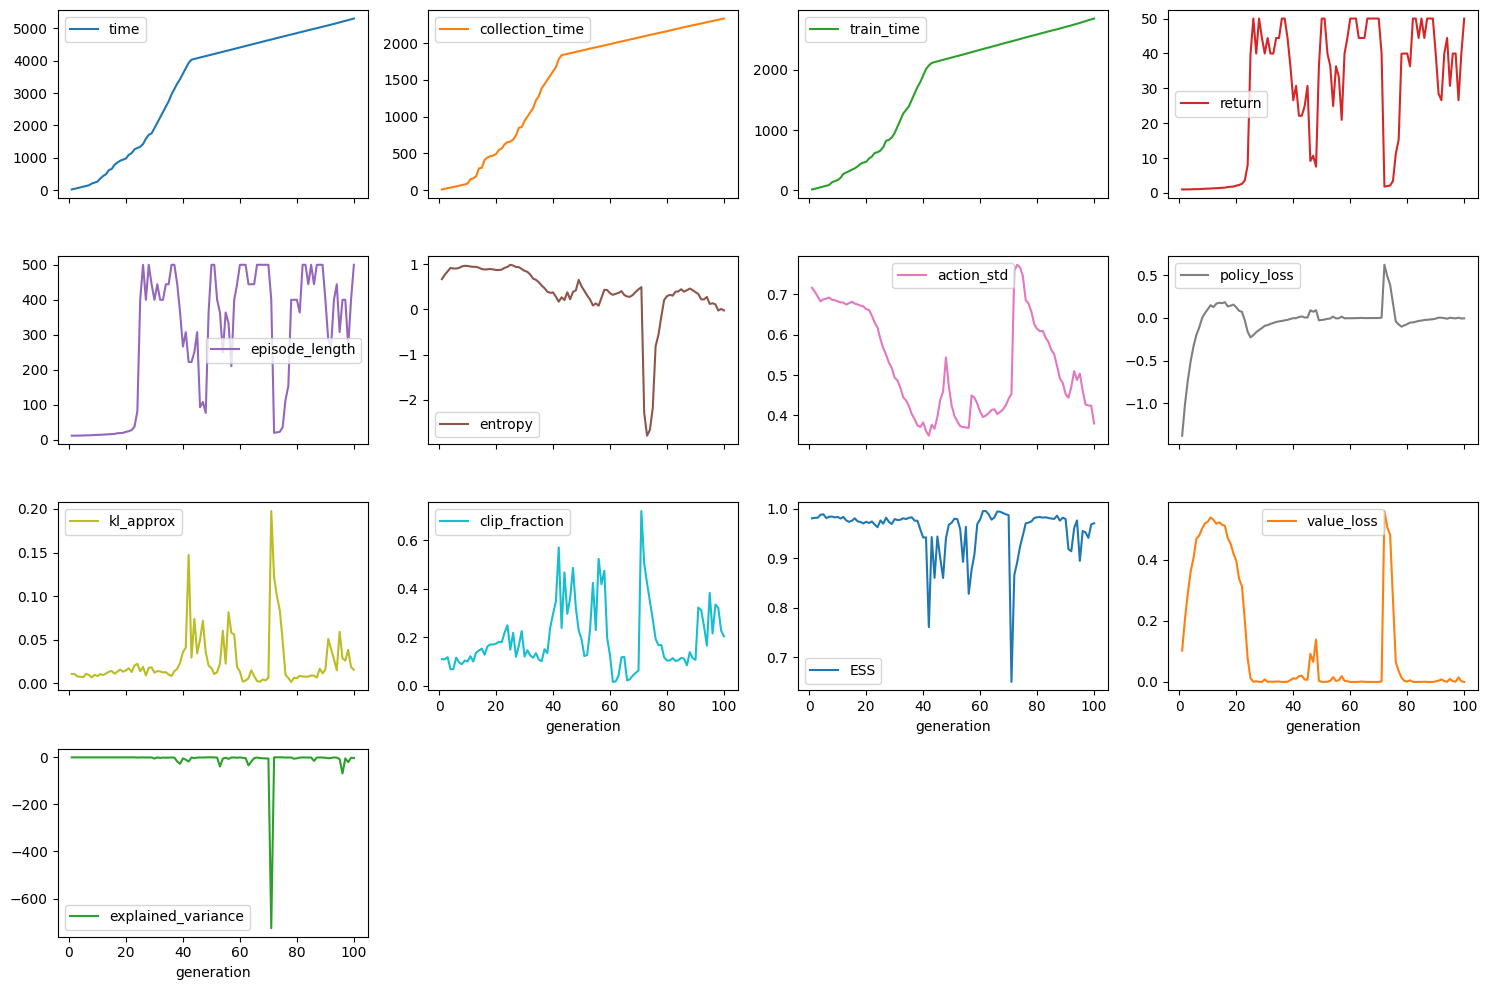

In [46]:
df.plot(subplots=True, layout=(4,4), figsize=(15, 10))
plt.tight_layout()

In [47]:
env = create_env(graphics=True)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

In [48]:
with torch.no_grad():
    data = env.rollout(1000, policy=policy, auto_cast_to_device=True).to(device)
data

Thread 0x16f497000 may have been prematurely finalized
Thread 0x1712d7000 may have been prematurely finalized
Thread 0x16d987000 may have been prematurely finalized
Setting up 7 worker threads for Enlighten.
Setting up 7 worker threads for Enlighten.
Thread 0x16dbfb000 may have been prematurely finalized
Setting up 7 worker threads for Enlighten.
Setting up 7 worker threads for Enlighten.
Thread 0x16c473000 may have been prematurely finalized
Thread 0x16fd37000 may have been prematurely finalized
Thread 0x16fdc3000 may have been prematurely finalized
Thread 0x16def7000 may have been prematurely finalized
Thread 0x16df83000 may have been prematurely finalized
Thread 0x16c5cf000 may have been prematurely finalized
Thread 0x16c65b000 may have been prematurely finalized
Memory Statistics:
[ALLOC_TEMP_TLS] TLS Allocator
  StackAllocators : 
    [ALLOC_TEMP_MAIN]
      Peak usage frame count: Memory Statistics:
[ALLOC_TEMP_TLS] TLS Allocator
[1.0 KB-2.0 KB]: 1393 frames  StackAllocators : 
,

KeyboardInterrupt: 

In [45]:
env.close()

In [44]:
data["next", "agents", "truncated"].sum().cpu().item(), data["next", "agents", "terminated"].sum().cpu().item()

(12, 0)

In [43]:
# Aggregated done signal
data["next", "done"] = data["next", "agents", "done"].squeeze().any(-1)

compute_trajectory_metrics(data)

{'return': 100.0000228881836,
 'episode_length': 1000.0,
 'entropy': 1.4782472848892212,
 'action_std': 0.07713016122579575}

In [46]:
collection_percent, train_percent = df["collection_time"].iloc[-1]/df["time"].iloc[-1], df["train_time"].iloc[-1]/df["time"].iloc[-1]
collection_percent, train_percent = float(collection_percent)*100, float(train_percent)*100
other_percent = 100 - collection_percent - train_percent
print(f"percent time collecting: {collection_percent:.2f}, percent time training: {train_percent:.2f}, other percent: {other_percent:.2f}")

percent time collecting: 68.06, percent time training: 30.40, other percent: 1.54
